# Training parameterized quantum circuits
# Quantum gradients

How to train circuit-based models using gradient based methods. 

The goal in the case of classical models is to minimize the cost or loss function which is the objective function via the vector of parameters $\vec{\theta}$. In the case where we train a parameterized quantum circuit model, the function to minimize is the expected value $\langle \Psi(\vec{\theta}) \mid \hat{H} \mid \Psi(\vec{\theta})\rangle$ with $\hat{H}$ the Hamiltonian operator defined by the Schrödinger equation $$i\hbar \frac{d|\Psi(\vec{\theta})\rangle}{d\theta} = \hat{H} |\Psi(\vec{\theta})\rangle $$

The expectation value is what we’d expect to measure if we averaged out a large number of results.


The quantum approach has two fundamental steps :

1. Prepare the quantum state $|\Psi(\vec{\theta})\rangle$ called the *ansatz*

2. Measure the expectation value $\langle\,\Psi(\vec{\theta})\,|\,\hat{H}\,|\,\Psi(\vec{\theta})\,\rangle$

We need to define our ansatz $|\Psi(\vec{\theta})\rangle = U(\vec{\theta})|0\rangle$ with $U(\vec{\theta})$ the parametrized quantum circuit. In our case  $U(\vec{\theta})$ is the ``RealAmplitudes`` circuit on 2 qubits

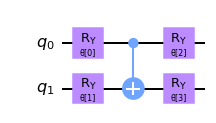

In [1]:
#%matplotlib inline

from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear').decompose()
ansatz.draw('mpl')

We define the Hamiltonian as $\hat{H} = \hat{Z} \otimes \hat{Z}$

The Pauli-$\hat{Z}$ gate is a single-qubit rotation through $\pi$ radians around the $z$-axis.

$$ \hat{Z} = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} $$

$$\hat{Z} \otimes \hat{Z} =  \bigg[\hat{z}_{ij}  \hat{Z} \bigg]_{ij} = \begin{bmatrix} 1 & 0 & 0 & 0  \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} $$

In [2]:
from qiskit.opflow import Z

hamiltonian = Z ^ Z

Putting them together to make the expectation value : $\langle\,\Psi(\vec{\theta})\,|\,\hat{H}\,|\,\Psi(\vec{\theta})\,\rangle$

In [3]:
from qiskit.opflow import StateFn, PauliExpectation

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

Next we write a function to simulate the measurement of the expectation value

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(pauli_basis, params=value_dict).eval()  
    return np.real(result)

## Vanilla gradient

In [5]:
import numpy as np

point = np.random.random(ansatz.num_parameters)
index = 2

In [6]:
eps = 0.2
# make identity vector with a 1 at index ``index``, otherwise 0
e_i = np.identity(point.size)[:, index]

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)
print(finite_difference)

-0.21972656249999972


We use ``Gradient`` class

In [7]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=eps)
grad = shifter.convert(expectation, params=ansatz.parameters[index])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


-0.24353027343750022

In [8]:
eps = np.pi / 2
e_i = np.identity(point.size)[:, index]
plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / 2
    
print(finite_difference)

-0.22387695312499994


In [9]:
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[index])
sampler.convert(grad, value_dict).eval().real

-0.23278808593749994

We see that the calculated analytic gradient is fairly similar to the calculated finite difference gradient.

Now that we know to calculate gradients, let's try optimizing the expectation value!

First we fix an initial point for reproducibility.

In [10]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

Similar to how we had a function to evaluate the expectation value, we'll need a function to evaluate the gradient.

In [11]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)

To compare the convergence of the optimizers, we can keep track of the loss at each step by using a callback function.



1. Update parameters $\theta_n \longrightarrow \theta_{n+1}$

2. Compute $\langle\,\Psi(\theta_n)\,|\,\hat{H}\,|\,\Psi(\theta_n)\,\rangle$

3. Update parameters with the function value

In [12]:
from qiskit.algorithms.optimizers import GradientDescent

gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_callback)

We start the optimization and plot the loss

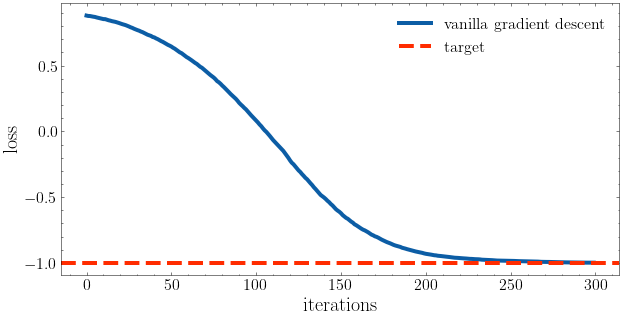

In [13]:
x_opt, fx_opt, nfevs = gd.optimize(
    initial_point.size,    # number of parameters
    evaluate_expectation,  # function to minimize
    gradient_function=evaluate_gradient,  # function to evaluate gradient
    initial_point=initial_point  # initial point
)

import matplotlib.pyplot as plt
import numpy as np

plt.style.use(['science'])
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

plt.figure(figsize=(10, 5))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend(prop={'size': 16});

## Natural gradient

The idea of natural gradients is to change the way we determine $\theta_{n+1}$ from $\theta_n$
, by considering the sensitivity of the model. In vanilla gradients, we used the Euclidean distance between them: $d = \lVert \vec{\theta}_{n+1} - \vec{\theta}_n \rVert_2$
, but we saw that this doesn't take the loss landscape into account. With natural gradients, we instead use a distance that depends on our model: 
$d = \lVert \langle\,\Psi(\vec{\theta}_n)\,| \,\Psi(\vec{\theta}_{n+1})\,\rangle \rVert^2$ .

In [14]:
from qiskit.opflow import NaturalGradient

In [15]:
natural_gradient = (NaturalGradient(regularization='ridge')
                    .convert(expectation))
natural_gradient_in_pauli_basis = PauliExpectation().convert(
                                                    natural_gradient)
sampler = CircuitSampler(quantum_instance, caching="all")

def evaluate_natural_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(natural_gradient, params=value_dict).eval()  
    return np.real(result)    

print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.71587274 -0.8645708  -0.98086144 -0.33820197]


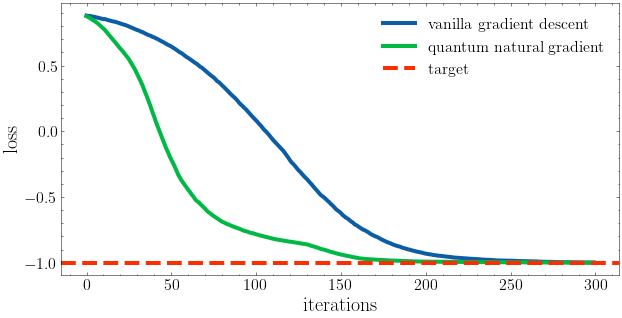

In [16]:
qng_loss = []
def qng_callback(nfevs, x, fx, stepsize):
    qng_loss.append(fx)
qng = GradientDescent(maxiter=300,
                      learning_rate=0.01,
                      callback=qng_callback)

x_opt, fx_opt, nfevs = (
    qng.optimize(initial_point.size, 
                 evaluate_expectation, 
                 gradient_function=evaluate_natural_gradient,
                 initial_point=initial_point))

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend(prop={'size': 16});

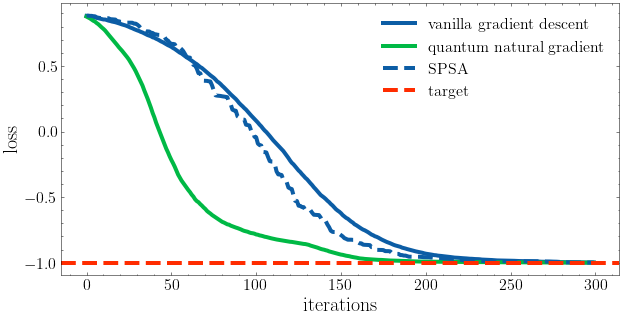

In [17]:
from qiskit.algorithms.optimizers import SPSA

spsa_loss = []
def spsa_callback(nfev, x, fx, stepsize, accepted):
    spsa_loss.append(fx)

spsa = SPSA(maxiter=300, learning_rate=0.01,
            perturbation=0.01, callback=spsa_callback)

x_opt, fx_opt, nfevs = spsa.optimize(initial_point.size, 
                                     evaluate_expectation, 
                                     initial_point=initial_point)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_loss, 'C0', ls='--', label='SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend(prop={'size': 16});

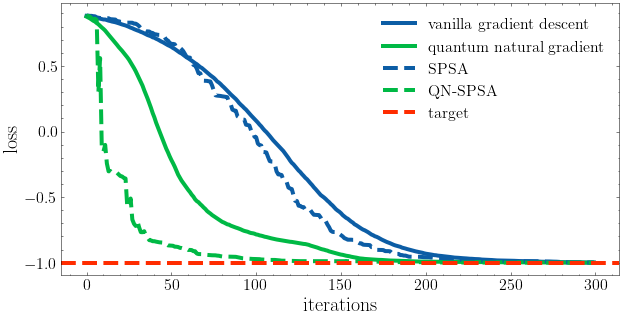

In [18]:
from qiskit.algorithms.optimizers import QNSPSA

qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

fidelity = QNSPSA.get_fidelity(ansatz,
                               quantum_instance,
                               expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01,
                                       perturbation=0.01,
                                       callback=qnspsa_callback)
                                       
x_opt, fx_opt, nfevs = qnspsa.optimize(initial_point.size, 
                                       evaluate_expectation, 
                                       initial_point=initial_point)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_loss, 'C1', ls='--', label='QN-SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend(prop={'size': 16});

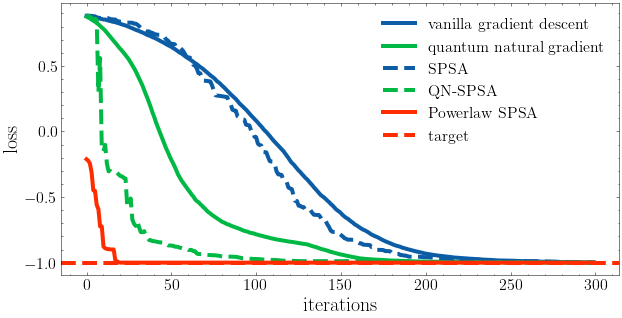

In [19]:
autospsa_loss = []

def autospsa_callback(nfev, x, fx, stepsize, accepted):
    autospsa_loss.append(fx)

autospsa = SPSA(maxiter=300,
                learning_rate=None,
                perturbation=None,
                callback=autospsa_callback)

x_opt, fx_opt, nfevs = autospsa.optimize(initial_point.size, 
                                         evaluate_expectation, 
                                         initial_point=initial_point)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(gd_loss, 'C0', label='Vanilla GradientDescent')
plt.plot(qng_loss, 'C1', label='Quantum Natural Gradient')
plt.plot(spsa_loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_loss, 'C1', ls='--', label='QN-SPSA')
plt.plot(autospsa_loss, 'C3', label='Powerlaw SPSA')
plt.axhline(-1, c='C3', ls='--', label='Target')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(prop={'size': 16});